In [1]:
import sys
sys.path.append("../scripts")
from timeseries_model import (
 prepare_data, run_arima, run_lstm, evaluate_performance
)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
full_df = pd.read_csv("../data/processed/market_data_processed.csv", parse_dates=["Date"])

In [4]:
train_tsla, test_tsla = prepare_data(full_df, asset_name='TSLA')

print(f"Training set size: {len(train_tsla)}")
print(f"Testing set size: {len(test_tsla)}")

Training set size: 2516
Testing set size: 259


2. Run ARIMA Model

In [5]:
arima_forecast, arima_order = run_arima(train_tsla, test_tsla)
print(f"Optimal ARIMA Order: {arima_order}")

# Evaluate ARIMA
arima_metrics = evaluate_performance(test_tsla, arima_forecast)
print("ARIMA Performance:", arima_metrics)

c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

Optimal ARIMA Order: (0, 1, 0)
ARIMA Performance: {'MAE': 69.4989569233191, 'RMSE': np.float64(82.93461282588196), 'MAPE': np.float64(22.557915255182202)}


c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppo

3. Run LSTM Model

In [6]:
# Note: This might take a minute depending on your GPU/CPU
lstm_forecast = run_lstm(train_tsla, test_tsla, window_size=60)

# Evaluate LSTM
lstm_metrics = evaluate_performance(test_tsla, lstm_forecast)
print("LSTM Performance:", lstm_metrics)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
LSTM Performance: {'MAE': 16.07076366527661, 'RMSE': np.float64(20.171612645160277), 'MAPE': np.float64(4.545435437249043)}


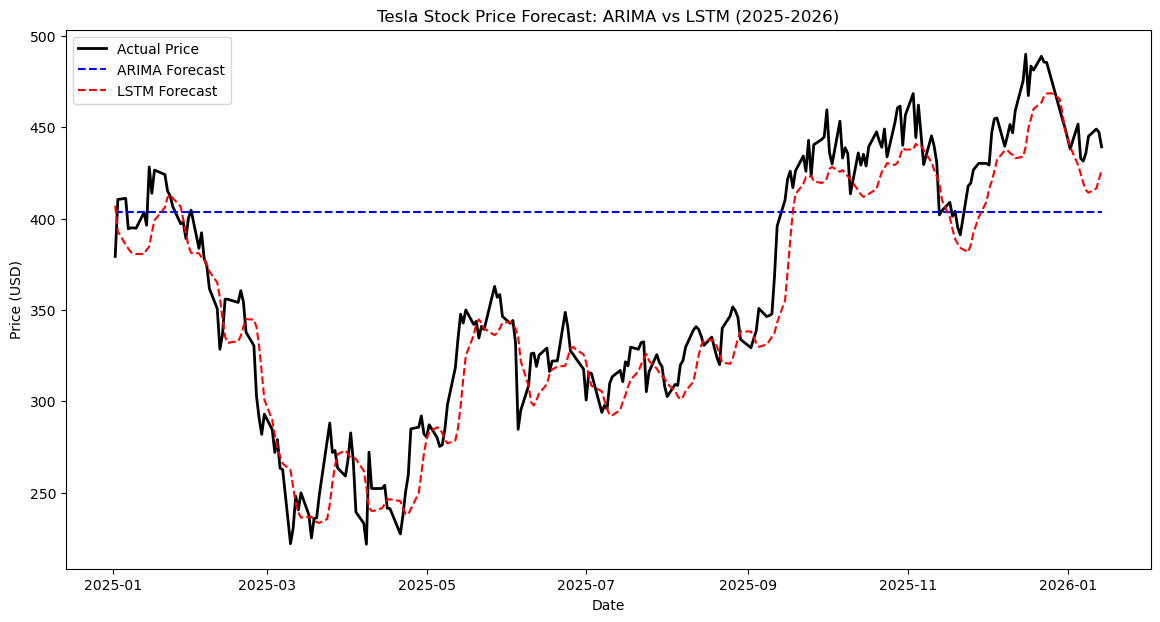

In [8]:


plt.figure(figsize=(14, 7))
plt.plot(test_tsla.index, test_tsla.values, label='Actual Price', color='black', lw=2)
plt.plot(test_tsla.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(test_tsla.index, lstm_forecast, label='LSTM Forecast', color='red', linestyle='--')

plt.title('Tesla Stock Price Forecast: ARIMA vs LSTM (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()